In [3]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
age_details = pd.read_csv('D:\covid19\covid19-in-india\AgeGroupDetails.csv')
india_covid_19 = pd.read_csv('D:\covid19\covid19-in-india\covid_19_india.csv')
hospital_beds = pd.read_csv('D:\covid19\covid19-in-india\HospitalBedsIndia.csv')
individual_details = pd.read_csv('D:\covid19\covid19-in-india\IndividualDetails.csv')
ICMR_details = pd.read_csv('D:\covid19\covid19-in-india\ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv('D:\covid19\covid19-in-india\ICMRTestingLabs.csv')
state_testing = pd.read_csv('D:\covid19\covid19-in-india\StatewiseTestingDetails.csv')
population = pd.read_csv('D:\covid19\covid19-in-india\population_india_census2011.csv')

In [5]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-19-2020.csv')
india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'])
state_testing['Date'] = pd.to_datetime(state_testing['Date'])

# Data Visualization 
(Age Group Analysis) 

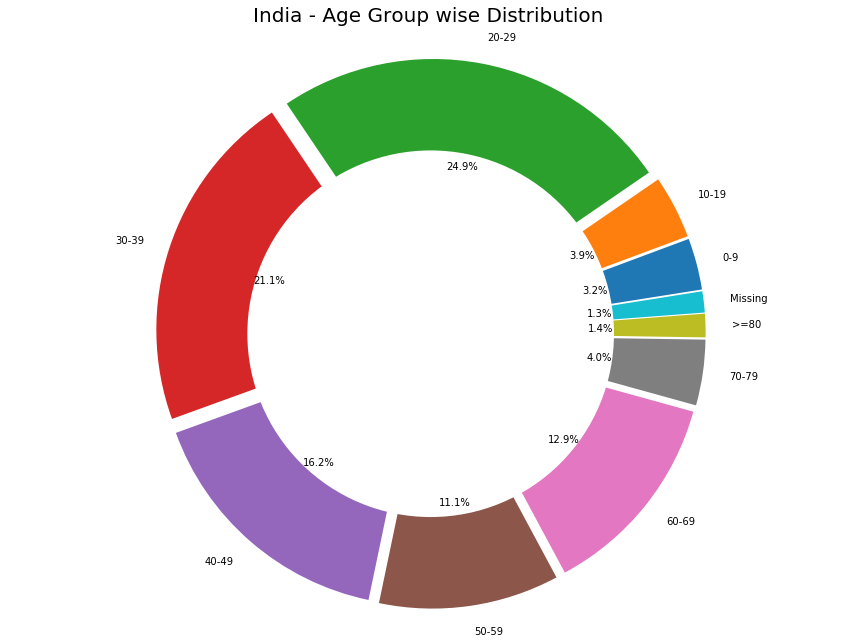

In [6]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (12,9))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()


In [7]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

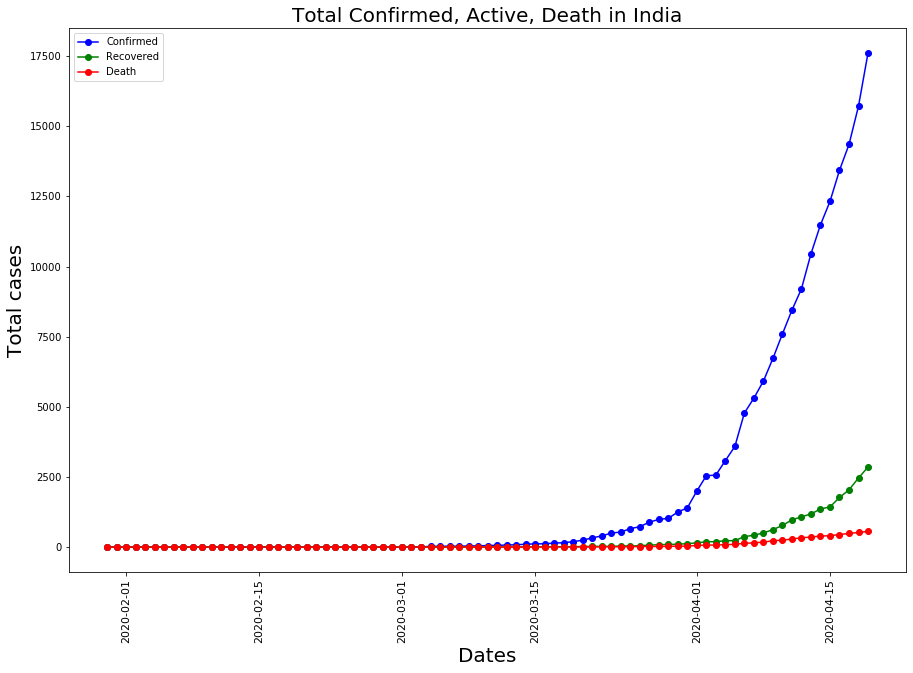

In [8]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

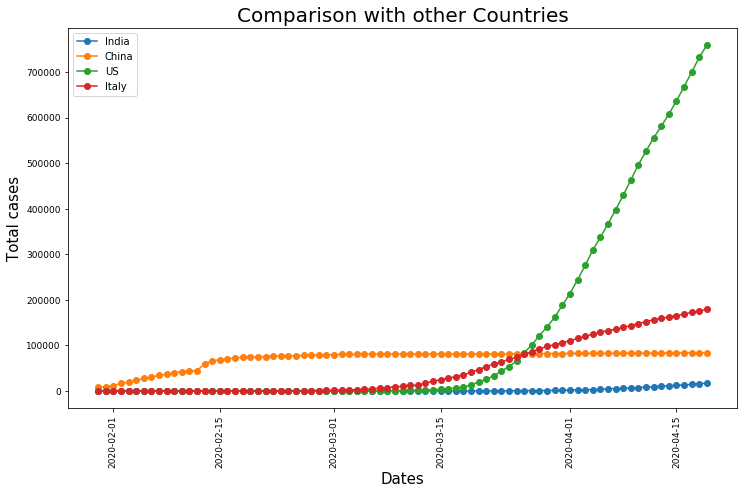

In [9]:
countries = ['India','China','US', 'Italy']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (12,7))
plt.xticks(rotation = 90 ,fontsize = 9)
plt.yticks(fontsize = 9)
plt.xlabel("Dates",fontsize = 15)
plt.ylabel('Total cases',fontsize = 15)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

# Though being highly populated the relative confimred cases of India is low compared to other countries. This could be because of two reasons:

1). 21 day lockdown imposed by Honourable Prime Minister Narendra Modi

2). Low testing rate 

Without lockdown, India would have 2 lakh Covid-19 cases by now: Health Ministry Stated this.

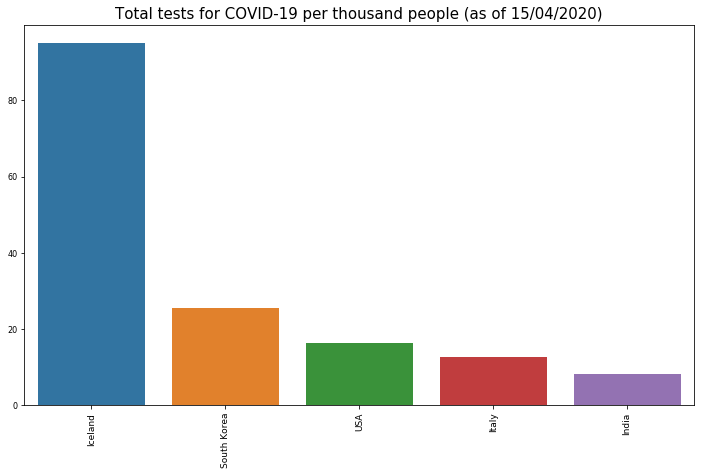

In [10]:
countries = ['Iceland','South Korea','USA','Italy','India']
value = [95.05,25.65,16.44,12.63,8.09] 
plt.figure(figsize= (12,7))
plt.xticks(rotation = 90 ,fontsize = 9)
plt.yticks(fontsize = 8)
plt.title("Total tests for COVID-19 per thousand people (as of 15/04/2020)" , fontsize = 15)
sns.barplot(x=countries,y=value);

Iceland has achieved something that no other country has achieved: tested around 10% of its population. The testing capacity of South Korea is appealing which is one big reason for the decline in number of new cases.

# Statewise Scenario

In [11]:
state_details = pd.pivot_table(india_covid_19, values=['Confirmed','Deaths','Cured'], index='State/UnionTerritory', aggfunc='max')
state_details['Recovery Rate'] = round(state_details['Cured'] / state_details['Confirmed'],2)
state_details['Death Rate'] = round(state_details['Deaths'] /state_details['Confirmed'], 2)
state_details = state_details.sort_values(by='Confirmed', ascending= False)
state_details.style.background_gradient(cmap='Reds')

,Confirmed,Cured,Deaths,Recovery Rate,Death Rate
State/UnionTerritory,,,,,
Maharashtra,2919,295,187,0.100000,0.060000
Delhi,1578,42,32,0.030000,0.020000
Tamil Nadu,1242,118,14,0.100000,0.010000
Madhya Pradesh,1120,64,53,0.060000,0.050000
Rajasthan,1023,147,3,0.140000,0.000000
Gujarat,871,64,36,0.070000,0.040000
Uttar Pradesh,773,68,13,0.090000,0.020000
Telengana,698,120,18,0.170000,0.030000
Andhra Pradesh,534,20,14,0.040000,0.030000


When we see above table or figure the most darkest part in parameters(confirmed cure death ) are the most hotspot areas and the part which dark in recovery rate parameter are those areas which getting cases but the people of those areas are recovering very fastly or we can say that increment in cases and recovery phase their is not much gap.

# Now we move more deeper for seeing the exact scenario of covid 19 in these hotspots states and which city is biggest reason of making the state in top level in terms of cases: 

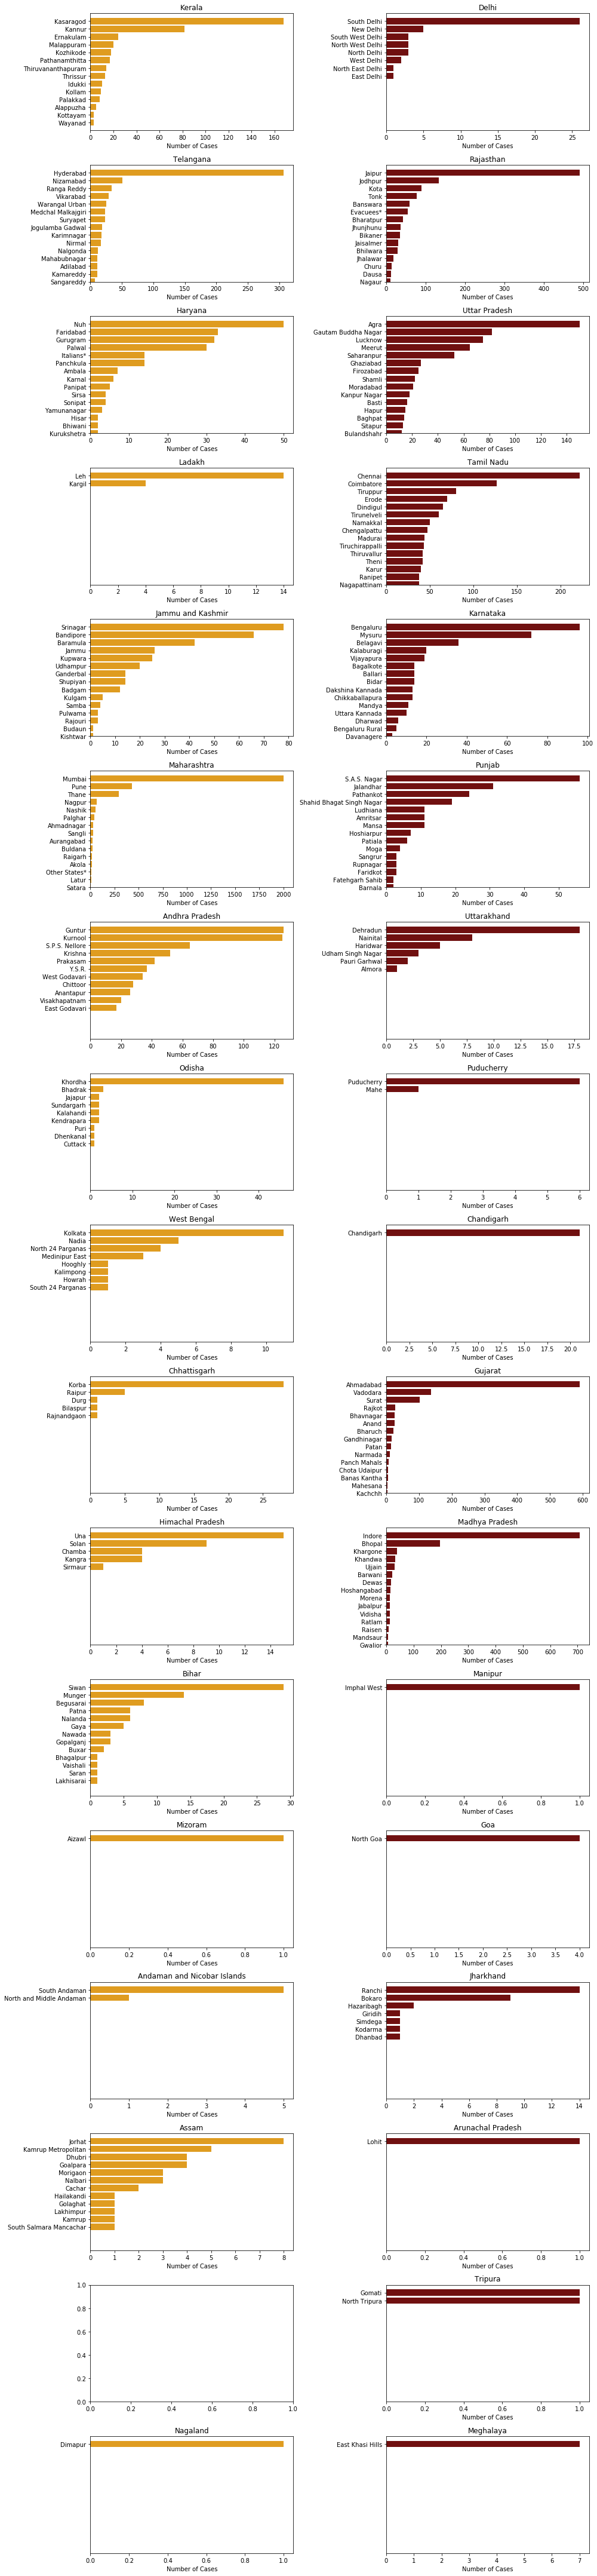

In [12]:
colors_list = ['orange','maroon']
states = individual_details['detected_state'].unique()
if len(states)%2==0:
    n_rows = int(len(states)/2)
else:
    n_rows = int((len(states)+1)/2)    
plt.figure(figsize=(14,60))

for idx,state in enumerate(states):    
    plt.subplot(n_rows,2,idx+1)
    y_order = individual_details[individual_details['detected_state']==state]['detected_district'].value_counts().index
    try:
        g = sns.countplot(data=individual_details[individual_details['detected_state']==state],y='detected_district',orient='v',color=colors_list[idx%2],order=y_order)
        plt.xlabel('Number of Cases')
        plt.ylabel('')
        plt.title(state)
        plt.ylim(14,-1)
    except:
        pass
plt.tight_layout()
plt.show()

# Statewise Testing and Healthcare Scenario

we check hospitality system of each state in india so that government can prepare themselves for fighting this virus.

In [13]:
hospital_beds =hospital_beds.drop([36])
cols_object = list(hospital_beds.columns[2:8])

for cols in cols_object:
    hospital_beds[cols] = hospital_beds[cols].astype(int,errors = 'ignore')

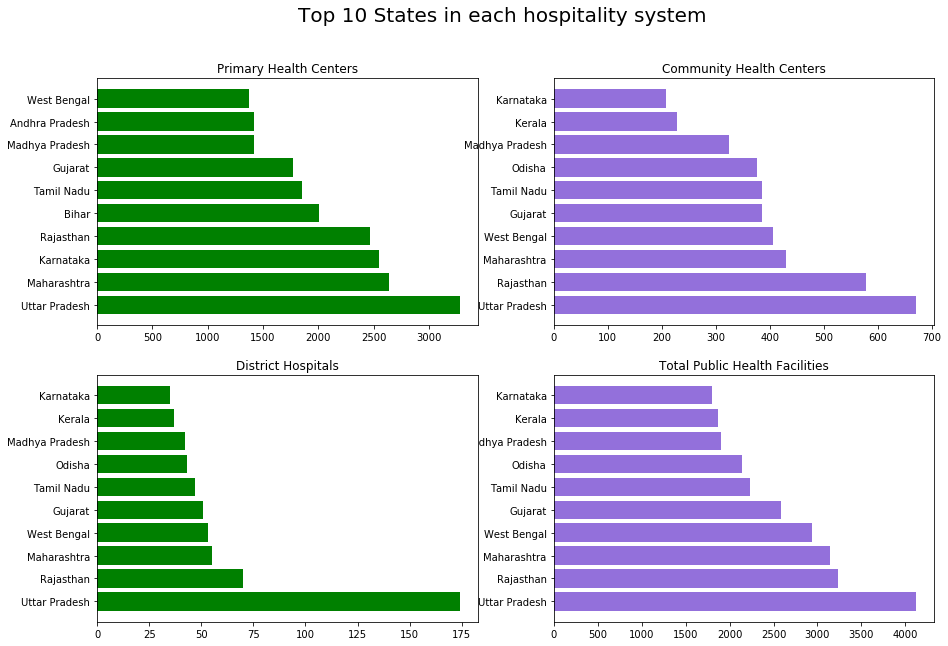

In [14]:
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')

plt.figure(figsize=(15,10))
plt.suptitle('Top 10 States in each hospitality system',fontsize=20)
plt.subplot(221)
plt.title('Primary Health Centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color ='Green');

plt.subplot(222)
plt.title('Community Health Centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color = '#9370db');

plt.subplot(224)
plt.title('Total Public Health Facilities')
plt.barh(top_10_community['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#9370db');

plt.subplot(223)
plt.title('District Hospitals')
plt.barh(top_10_community['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color = 'Green');


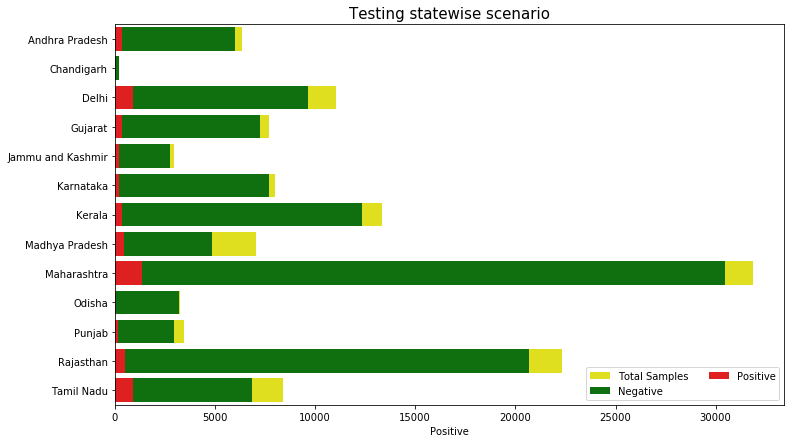

In [15]:
state_test = pd.pivot_table(state_testing, values=['TotalSamples','Negative','Positive'], index='State', aggfunc='max')
state_names = list(state_test.index)

plt.figure(figsize=(12,7))
sns.set_color_codes("pastel")
sns.barplot(x="TotalSamples", y= state_names, data=state_test,label="Total Samples", color = 'Yellow')
sns.barplot(x='Negative', y=state_names, data=state_test,label='Negative', color= 'Green')
sns.barplot(x='Positive', y=state_names, data=state_test,label='Positive', color='Red')
plt.title('Testing statewise scenario',fontsize = 15)
plt.legend(ncol=2, loc="lower right", frameon=True);




# Prediction For Future Status Of Covid-19 Cases in India

In [16]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.1645031577662925


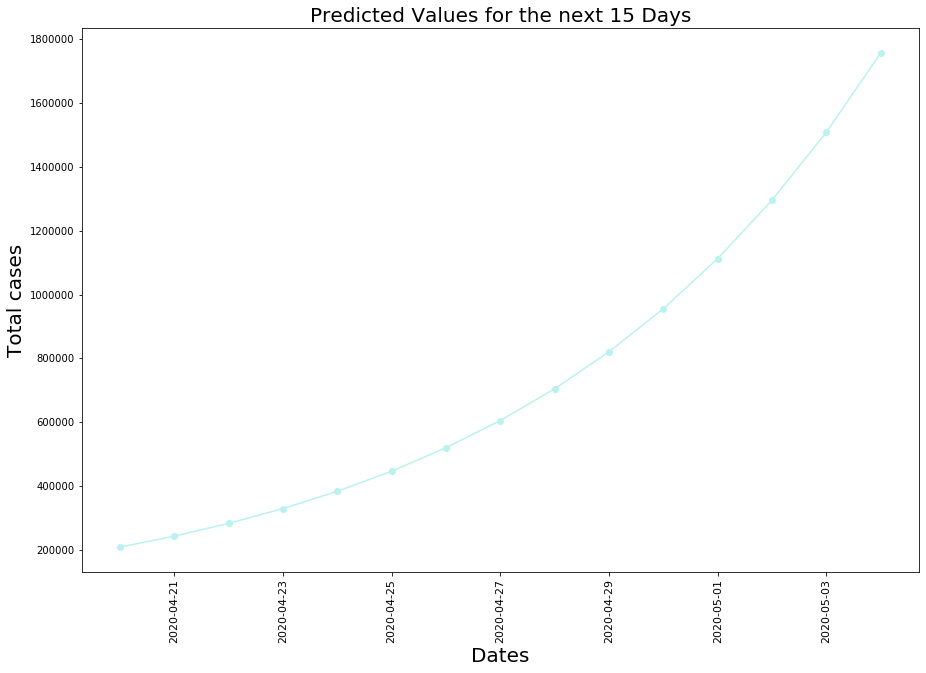

In [17]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[3][len(dates_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')


In [18]:
train = pd.read_csv(r'D:\covid19\covid19-in-india\covid19-global-forecasting-week-3\train.csv')
test = pd.read_csv(r'D:\covid19\covid19-in-india\covid19-global-forecasting-week-3\test.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

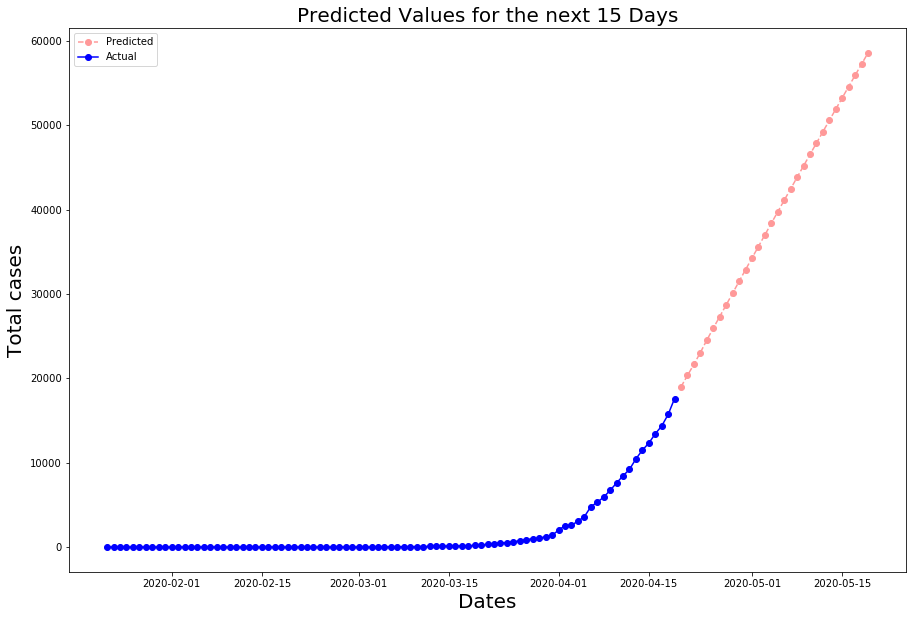

In [19]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

# Sigmoid model

I thought of a sigmoidal function because China's data resembled a sigmoidal shape. Therefore, I try to fit sigmoid functions onto India's. Its just a guess as per the graph about the cases in India

In [20]:
train_data=pd.read_csv(r'D:\covid19\covid19-in-india\covid-19-all.csv')

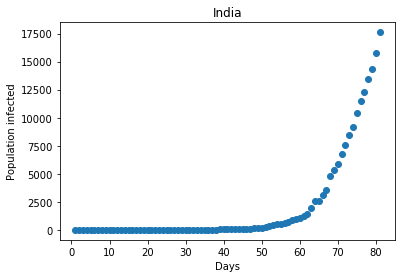

In [21]:
country_df = train_data[train_data['Country/Region']=='India'].groupby('Date')['Confirmed','Deaths'].sum()
country_df['day_count'] = list(range(1,len(country_df)+1))
ydata = country_df.Confirmed
xdata = country_df.day_count
country_df['rate'] = (country_df.Confirmed-country_df.Confirmed.shift(1))/country_df.Confirmed
country_df['increase'] = (country_df.Confirmed-country_df.Confirmed.shift(1))

plt.plot(xdata, ydata, 'o')
plt.title("India")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

# Sigmoid Function

[92.63362383  1.75222064  4.22892906]


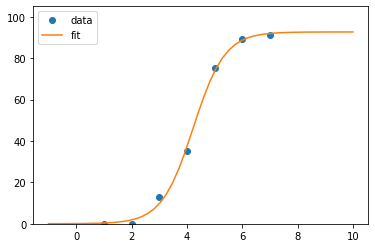

In [22]:
from scipy.optimize import curve_fit
import pylab


def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y
#country_df.ConfirmedCases
#country_df.day_count
xdata = np.array([1, 2, 3,4, 5, 6, 7])
ydata = np.array([0, 0, 13, 35, 75, 89, 91])


#a is the sigmoidal shape.
popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=([0.,0., 0.],[100,2, 10.]))
print(popt)

x = np.linspace(-1, 10, 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(-0.05, 105)
pylab.legend(loc='best')
pylab.show()


Sigmoid function,

Above image shows about fit Sigmoid Function - y = c/(1+np.exp(-a*(x-b))) and 3 coefficients [c, a, b]:

c - the maximum value (eventual maximum infected people, the sigmoid scales to this value eventually)

a - the sigmoidal shape (how the infection progress. The smaller, the softer the sigmoidal shape is)

b - the point where sigmoid start to flatten from steepening (the midpoint of sigmoid, when the rate of increase start to slow down)

In [23]:
in_df = train_data[train_data['Country/Region']=='India'].groupby('Date')['Confirmed','Deaths'].sum()
in_df = in_df[in_df.Confirmed>=100]

In [24]:
from scipy.optimize import curve_fit
import pylab
from datetime import timedelta

in_df['day_count'] = list(range(1,len(in_df)+1))
in_df['increase'] = (in_df.Confirmed-in_df.Confirmed.shift(1))
in_df['rate'] = (in_df.Confirmed-in_df.Confirmed.shift(1))/in_df.Confirmed


def sigmoid(x,c,a,b):
     y = c*1 / (1 + np.exp(-a*(x-b)))
     return y

xdata = np.array(list(in_df.day_count)[::2])
ydata = np.array(list(in_df.Confirmed)[::2])

population=1.332*10**9
popt, pcov = curve_fit(sigmoid, xdata, ydata, method='dogbox',bounds=([0.,0., 0.],[population,6, 100.]))
print(popt)

[6.66e+08 3.00e+00 5.00e+01]


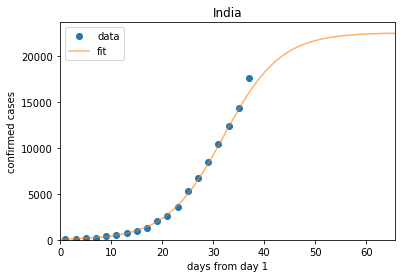

model start date: 2020-03-14
model start infection: 102
model fitted max infection at: 22500
model sigmoidal coefficient is: 0.18
model curve stop steepening, start flattening by day: 32
model curve flattens by day: 64


,Confirmed,Deaths,day_count,increase,rate
Date,,,,,
2020-03-14,102.0,2.0,1,NaN,NaN
2020-03-15,113.0,2.0,2,11.0,0.097345
2020-03-16,119.0,2.0,3,6.0,0.050420


,Confirmed,Deaths,day_count,increase,rate
Date,,,,,
2020-04-17,14352.0,486.0,35,922.0,0.064242
2020-04-18,15722.0,521.0,36,1370.0,0.087139
2020-04-19,17615.0,559.0,37,1893.0,0.107465


In [25]:
est_a = 22500
est_b = 0.18
est_c = 32
x = np.linspace(-1, in_df.day_count.max()+50, 50)
y = sigmoid(x,est_a,est_b,est_c)
pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit',alpha = 0.6)
pylab.ylim(-0.05, est_a*1.05)
pylab.xlim(-0.05, est_c*2.05)
pylab.legend(loc='best')
plt.xlabel('days from day 1')
plt.ylabel('confirmed cases')
plt.title('India')
pylab.show()


print('model start date:',in_df[in_df.day_count==1].index[0])
print('model start infection:',int(in_df[in_df.day_count==1].Confirmed[0]))
print('model fitted max infection at:',int(est_a))
print('model sigmoidal coefficient is:',round(est_b,3))
print('model curve stop steepening, start flattening by day:',int(est_c))
print('model curve flattens by day:',int(est_c)*2)
display(in_df.head(3))
display(in_df.tail(3))

From this, its seen that in case of India if the graph goes like that:

->max infection: 22500

->curve stop steepening, start flattening by day: 32 ,which is: 15/04/2020

->curve flattens by day: 64 which is: 17/05/2020